# Generate class weights pickle array

### Generate class weights array based on classes histogram

In [1]:
import sys; print('Python:',sys.version)
import torch; print('Pytorch:',torch.__version__)
import fastai; print('Fastai:',fastai.__version__)

Python: 3.8.8 (default, Feb 24 2021, 15:54:32) [MSC v.1928 64 bit (AMD64)]
Pytorch: 1.7.1
Fastai: 2.2.7


In [2]:
from fastai.basics import *
from fastai.callback.all import *
from fastai.vision.all import *
from torchvision.utils import save_image
import torch
import torchvision
from torchvision import transforms
from PIL import Image
import PIL 
import os

C:\Users\bruno\miniconda3\lib\site-packages\torch\cuda\__init__.py:52: UserWarning: CUDA initialization: Found no NVIDIA driver on your system. Please check that you have an NVIDIA GPU and installed a driver from http://www.nvidia.com/Download/index.aspx (Triggered internally at  ..\c10\cuda\CUDAFunctions.cpp:100.)
  return torch._C._cuda_getDeviceCount() > 0


## Load dataset


In [12]:
#pathToDataSet = '/mnt/c/Users/tomsq/Documents/UnB/2020.2/TG/dataset_v1/'
pathToDataSet = "../dataset_v1/sprint0/"
path_anno = pathToDataSet + 'gt/'
path_img = pathToDataSet + 'done/'
get_y_fn = lambda x : path_anno + f'{x.stem}_GT.png'

fnames = get_image_files(path_img)
print(len(fnames))

469


In [20]:
# get training and testing files from Multi Label Stratified Split (OPTIONAL)

"""
with open('../var/trainFilenames.pkl', 'rb') as f:
  trainFiles = pickle.load(f) #trainFiles is an array with image names that should be in the training phase
with open('../var/testFilenames.pkl', 'rb') as f:
  testFiles = pickle.load(f)

train_fnames = []
test_fnames = []
for i in range(0, len(fnames)):
    if fnames[i].name in trainFiles:
        train_fnames.append(fnames[i])
    elif fnames[i].name in testFiles:
        test_fnames.append(fnames[i])

print(len(train_fnames), len(test_fnames))

# continue the algorithm only for the these images
fnames = train_fnames + test_fnames
print(len(fnames))
"""

"\nwith open('../var/trainFilenames.pkl', 'rb') as f:\n  trainFiles = pickle.load(f) #trainFiles is an array with image names that should be in the training phase\nwith open('../var/testFilenames.pkl', 'rb') as f:\n  testFiles = pickle.load(f)\n\ntrain_fnames = []\ntest_fnames = []\nfor i in range(0, len(fnames)):\n    if fnames[i].name in trainFiles:\n        train_fnames.append(fnames[i])\n    elif fnames[i].name in testFiles:\n        test_fnames.append(fnames[i])\n\nprint(len(train_fnames), len(test_fnames))\n\n# continue the algorithm only for the these images\nfnames = train_fnames + test_fnames\nprint(len(fnames))\n"

## Generate DataSet Histogram

In [13]:
totalArray = []

for i in range(0,len(fnames)):
    img = Image.open(get_y_fn(fnames[i]))
    arr = np.asarray(img)
    totalArray += list(np.unique(arr,return_counts=False))

print('Array Generated')


Array Generated


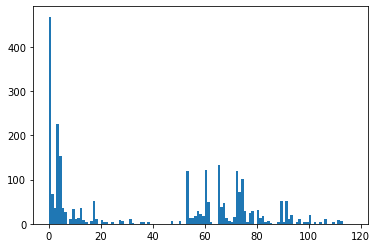

In [14]:
codes = np.loadtxt( pathToDataSet + 'classesNumberComplete.txt', dtype=str, delimiter='\n',encoding='utf') 
codes = [code.split(": ")[0] for code in codes] #pega apenas o ID de cada classe e ignora o nome

hist = plt.hist(totalArray, bins=len(codes), range=(0,len(codes)))
dicionario = {}


for code, contagem in zip(codes, hist[0]):
    dicionario[code] = int(contagem)

dicionario = {k: v for k, v in sorted(dicionario.items(), key=lambda item: item[1], reverse=True)} #sort



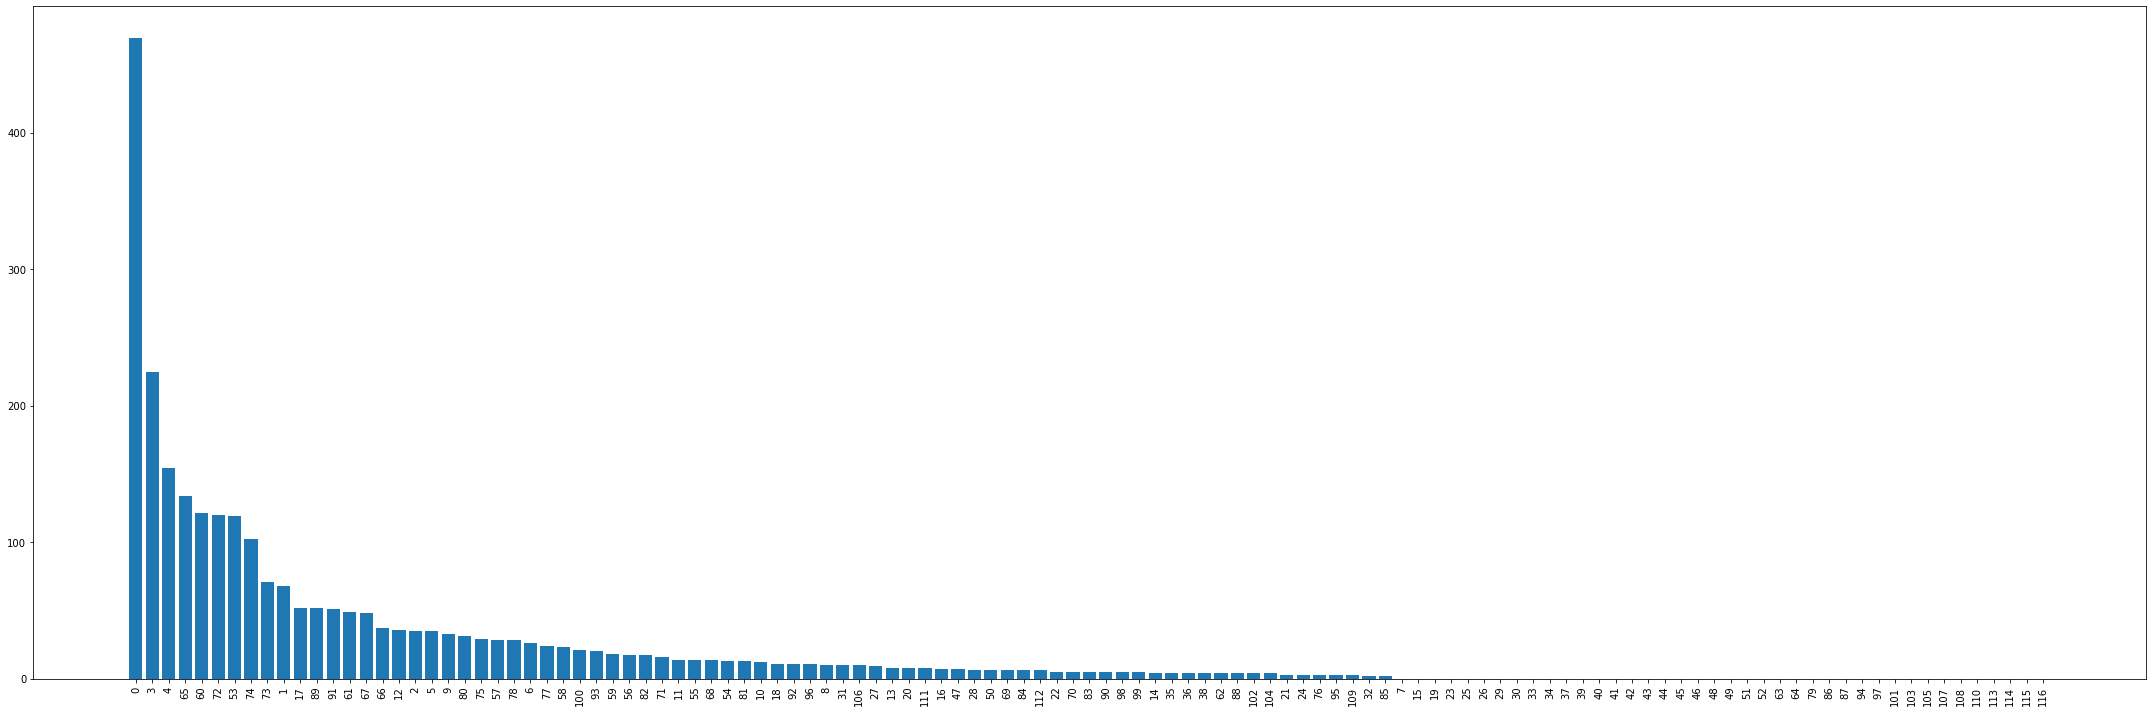

In [15]:
plt.figure(figsize=(30, 10))
plt.bar(*zip(*dicionario.items()))
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

In [16]:
#The idx 1 is related to the class that appears the most, except for the backGround class 0.

print('Class that most appears >>> ', list(dicionario.items())[1][0])
print('Appears >>> ', list(dicionario.items())[1][1], ' times')

dataBaseImageNumberThreshold =  list(dicionario.items())[1][1]

Class that most appears >>>  3
Appears >>>  225  times


## Class Weights based on dictionary

In [28]:
# calculate class weights from sklearn. I think the results are wrong because they consider Single Label Classification Problems

#from sklearn.utils import class_weight

#class_weights = class_weight.compute_class_weight(class_weight="balanced", classes=np.unique(totalArray), y=totalArray)
#class_weights

In [17]:
# calculate class weights

classWeights = {}
totalValuesSum = sum(dicionario.values())
for key, value in dicionario.items():
    classWeights[key] = (1 - (value/totalValuesSum))
    #classWeights[key] = 1 / value if value != 0 else 1  # another way of calculating weights


In [30]:
# normalize weights between two values (OPTIONAL)

"""
maxValue = max(classWeights.values())
minValue = min(classWeights.values())
start = 0.5
end = 1
width = end - start

for key, value in classWeights.items():
    classWeights[key] = (value - minValue)/(maxValue - minValue) * width + start
"""

'\nmaxValue = max(classWeights.values())\nminValue = min(classWeights.values())\nstart = 0.1\nend = 1\nwidth = end - start\n\nfor key, value in classWeights.items():\n    classWeights[key] = (value - minValue)/(maxValue - minValue) * width + start\n'

In [19]:
# create array from class weights dict

classWeights = {k: v for k, v in sorted(classWeights.items(), key=lambda item: int(item[0]), reverse=False)} #sort
classWeights = {k: v for k, v in classWeights.items() if v != 1.0} #remove classes that does not appear (weights = 1)
classWeightsArray = list(classWeights.values())

print(classWeightsArray)

[0.8203065134099616, 0.9739463601532568, 0.9865900383141762, 0.9137931034482758, 0.9409961685823754, 0.9865900383141762, 0.9900383141762452, 0.9961685823754789, 0.9873563218390805, 0.9954022988505747, 0.9946360153256705, 0.9862068965517241, 0.9969348659003832, 0.9984674329501916, 0.9973180076628353, 0.9800766283524904, 0.9957854406130269, 0.9969348659003832, 0.9988505747126437, 0.9980842911877394, 0.9988505747126437, 0.996551724137931, 0.9977011494252873, 0.9961685823754789, 0.9992337164750957, 0.9984674329501916, 0.9984674329501916, 0.9984674329501916, 0.9973180076628353, 0.9977011494252873, 0.9544061302681992, 0.9950191570881226, 0.9946360153256705, 0.9934865900383142, 0.989272030651341, 0.9911877394636015, 0.993103448275862, 0.953639846743295, 0.9812260536398467, 0.9984674329501916, 0.9486590038314177, 0.985823754789272, 0.9816091954022989, 0.9946360153256705, 0.9977011494252873, 0.9980842911877394, 0.9938697318007663, 0.9540229885057472, 0.9727969348659004, 0.960919540229885, 0.988

In [20]:
len(classWeightsArray)

77

In [21]:
# dump arrays into pickle file

with open('./sprint0/classWeights.pkl', 'wb') as f:
  pickle.dump(classWeightsArray, f)